Matplotlib is building the font cache; this may take a moment.


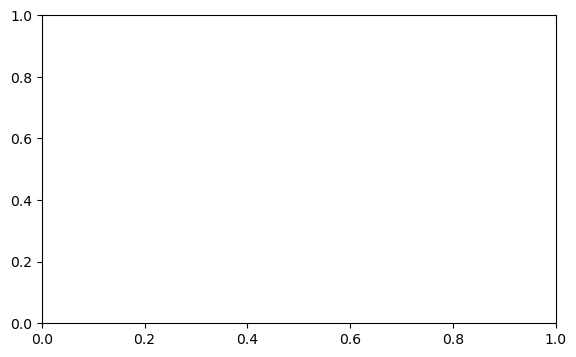

In [1]:

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading

# ฟังก์ชันในการตรวจจับคน
def detect_people(video_file, zones_count, zone_id):
    cap = cv2.VideoCapture(video_file)
    total_people = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
       
        # ตรวจจับคน
        people_count = find_human(frame)
        total_people += people_count

        # อัปเดตจำนวนคนในโซน
        zones_count[zone_id] += people_count

        # วาดกรอบบนวิดีโอ
        cv2.putText(frame, f'Zone {zone_id + 1} People: {people_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # แสดงวิดีโอ
        display_image(frame)

    cap.release()
    return total_people

# ฟังก์ชันในการแสดงภาพ
def display_image(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(frame, (320, 240))  # ปรับขนาดเพื่อให้เล็กลง
    ax.clear()
    ax.imshow(img)
    ax.axis('off')  # ไม่แสดงแกน
    canvas.draw()

# ฟังก์ชันการตรวจจับคน (ที่ใช้ YOLO)
def find_human(image):
    # TODO: ใช้ YOLOv5 ในการตรวจจับคน
    # ใช้ไฟล์ที่ฝึกมาแล้วในโฟลเดอร์ของ YOLOv5
    # ตัวอย่าง: results = model.predict(image)
    # ส่งกลับจำนวนคนที่ตรวจจับได้
    return np.random.randint(0, 5)  # ใช้สุ่มเพื่อทดสอบ

# ฟังก์ชันในการสร้าง heatmap
def create_heatmap(zones_count):
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(zones_count.reshape(1, -1), annot=True, fmt="d", cmap="coolwarm", cbar=False, ax=ax)
    ax.set_title("People Count Heatmap by Zone")
    plt.xlabel("Zone")
    plt.ylabel("Count")
    return fig

# ฟังก์ชันในการบันทึกลง Excel
def save_to_excel(zones_count):
    df = pd.DataFrame(zones_count.reshape(1, -1), columns=["Zone 1", "Zone 2", "Zone 3"])
    df.to_excel("people_count_zones.xlsx", index=False)

# ฟังก์ชันในการประมวลผลวิดีโอ
def process_videos():
    video_files = ["1video.mp4", "2video.mp4", "3video.mp4"]
    zones_count = np.zeros(3)  # จำนวนคนในแต่ละโซน

    threads = []
    for i, video_file in enumerate(video_files):
        t = threading.Thread(target=detect_people, args=(video_file, zones_count, i))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    # แสดงผล heatmap และบันทึกลง Excel
    fig = create_heatmap(zones_count)
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    save_to_excel(zones_count)

# สร้าง GUI
root = tk.Tk()
root.title("People Counting and Heatmap")
root.geometry("800x400")

# พื้นที่แสดงวิดีโอ
fig, ax = plt.subplots(figsize=(3, 3))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# ปุ่มเริ่มการประมวลผล
start_button = tk.Button(root, text="Start Processing", command=process_videos)
start_button.pack(pady=20)

root.mainloop()


In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import threading
from deep_sort.deep_sort.tracker import Tracker as DeepSortTracker
from deep_sort.tools import generate_detections as gdet
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.detection import Detection

class Tracker:
    def __init__(self):
        max_cosine_distance = 0.4
        nn_budget = None
        encoder_model_filename = 'model_data/mars-small128.pb'
        metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
        self.tracker = DeepSortTracker(metric)
        self.encoder = gdet.create_box_encoder(encoder_model_filename, batch_size=1)

    def update(self, frame, detections):
        if len(detections) == 0:
            self.tracker.predict()
            self.tracker.update([])  
            return []

        bboxes = np.asarray([d[:-1] for d in detections])
        bboxes[:, 2:] = bboxes[:, 2:] - bboxes[:, 0:2]
        scores = [d[-1] for d in detections]
        features = self.encoder(frame, bboxes)
        dets = [Detection(bbox, scores[i], features[i]) for i, bbox in enumerate(bboxes)]
        self.tracker.predict()
        self.tracker.update(dets)

        tracked_objects = []
        for track in self.tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            tracked_objects.append((track.track_id, track.to_tlbr()))

        return tracked_objects

def detect_and_track(video_file, zones_count, zone_id):
    cap = cv2.VideoCapture(video_file)
    tracker = Tracker()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # การจำลองการตรวจจับวัตถุ (ควรใช้ YOLO หรือโมเดลอื่นเพื่อให้ได้ bounding box จริง)
        detections = [[50, 50, 200, 200, 0.9]]  # ใช้การสุ่มเพื่อทดสอบ

        tracked_objects = tracker.update(frame, detections)

        for obj_id, bbox in tracked_objects:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {obj_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            zones_count[zone_id] += 1  # เพิ่มจำนวนคนที่ตรวจพบในโซนนี้

        display_image(frame)

    cap.release()

def display_image(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(frame, (320, 240))
    ax.clear()
    ax.imshow(img)
    ax.axis('off')
    canvas.draw()

def create_heatmap(zones_count):
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(zones_count.reshape(1, -1), annot=True, fmt="d", cmap="coolwarm", cbar=False, ax=ax)
    ax.set_title("People Count Heatmap by Zone")
    return fig

def save_to_excel(zones_count):
    df = pd.DataFrame(zones_count.reshape(1, -1), columns=["Zone 1", "Zone 2", "Zone 3"])
    df.to_excel("people_count_zones.xlsx", index=False)

def process_videos():
    video_files = ["1video.mp4", "2video.mp4", "3video.mp4"]
    zones_count = np.zeros(3)

    threads = []
    for i, video_file in enumerate(video_files):
        t = threading.Thread(target=detect_and_track, args=(video_file, zones_count, i))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    fig = create_heatmap(zones_count)
    canvas_heatmap = FigureCanvasTkAgg(fig, master=root)
    canvas_heatmap.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    save_to_excel(zones_count)

# GUI สำหรับแสดงผล
root = tk.Tk()
root.title("People Tracking and Heatmap")
root.geometry("800x400")

fig, ax = plt.subplots(figsize=(3, 3))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

start_button = tk.Button(root, text="Start Processing", command=process_videos)
start_button.pack(pady=20)

root.mainloop()


In [ ]:
import cv2
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import numpy as np
import pandas as pd

# ฟังก์ชันแสดงวิดีโอและข้อมูลโซนต่าง ๆ
def process_video(video_file, zone_name):
    cap = cv2.VideoCapture(video_file)
    people_count = 0  # จำลองค่าคนที่ตรวจจับได้

    # สร้างเลเบลสำหรับโซน
    zone_label = tk.Label(root, text=f"{zone_name}: {people_count} คน")
    zone_label.pack()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # เพิ่มกรอบจำลองแผนที่
        cv2.rectangle(frame, (50, 50), (200, 200), (0, 255, 0), 2)  # ตัวอย่างโซน
        frame = cv2.putText(frame, f"Zone: {zone_name}", (60, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # แปลงภาพจาก OpenCV ไปยัง PIL เพื่อแสดงใน Tkinter
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)

        # แสดงผลในเลเบล
        video_label.configure(image=image)
        video_label.image = image

        root.update_idletasks()
        root.update()

    cap.release()
    zone_label.config(text=f"{zone_name}: {people_count} คน")  # แสดงผลจำนวนคนสุดท้าย

# ฟังก์ชันส่งข้อมูลไปยัง Excel
def save_to_excel(data):
    df = pd.DataFrame(data, columns=["Zone", "People Count"])
    df.to_excel("zone_people_count.xlsx", index=False)

# GUI setup
root = tk.Tk()
root.title("Zone Simulation Map with Video")
root.geometry("800x600")

video_label = tk.Label(root)
video_label.pack()

# จำลองการแสดงผลโซน
process_video("1video.mp4", "Zone 1")
process_video("2video.mp4", "Zone 2")
process_video("3video.mp4", "Zone 3")

# ส่งข้อมูลไปยัง Excel
zone_data = [("Zone 1", 5), ("Zone 2", 10), ("Zone 3", 3)]  # จำลองข้อมูลโซน
save_to_excel(zone_data)

root.mainloop()


In [ ]:
import cv2
import tkinter as tk
from PIL import Image, ImageTk
import pandas as pd

# ฟังก์ชันแสดงวิดีโอและข้อมูลโซน
def process_video(video_file, zone_name):
    cap = cv2.VideoCapture(video_file)
    people_count = 0  # จำลองจำนวนคนที่ตรวจจับได้ (แก้ไขให้ตรงตามจริงได้ในอนาคต)

    # สร้างเลเบลสำหรับแสดงจำนวนคนในโซน
    zone_label = tk.Label(root, text=f"{zone_name}: {people_count} คน")
    zone_label.pack()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # เพิ่มกรอบเพื่อจำลองโซนในแผนที่
        cv2.rectangle(frame, (50, 50), (200, 200), (0, 255, 0), 2)  # ตัวอย่างโซน
        frame = cv2.putText(frame, f"Zone: {zone_name}", (60, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # แปลงภาพจาก OpenCV ไปยัง PIL เพื่อแสดงใน Tkinter
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)

        # แสดงผลในเลเบล
        video_label.configure(image=image)
        video_label.image = image

        root.update_idletasks()
        root.update()

    cap.release()
    zone_label.config(text=f"{zone_name}: {people_count} คน")  # แสดงผลจำนวนคนสุดท้าย

# ฟังก์ชันส่งข้อมูลไปยัง Excel
def save_to_excel(data):
    df = pd.DataFrame(data, columns=["Zone", "People Count"])
    df.to_excel("zone_people_count.xlsx", index=False)

# GUI setup
root = tk.Tk()
root.title("Zone Simulation Map with Video")
root.geometry("800x600")

# Label สำหรับแสดงวิดีโอ
video_label = tk.Label(root)
video_label.pack()

# เรียกใช้ฟังก์ชันแสดงวิดีโอ
process_video("1video.mp4", "Zone 1")

# บันทึกข้อมูลไปยัง Excel
zone_data = [("Zone 1", 5)]  # จำลองข้อมูลโซน
save_to_excel(zone_data)

root.mainloop()


In [ ]:
# track code pt
from deep_sort.deep_sort.tracker import Tracker as DeepSortTracker
from deep_sort.tools import generate_detections as gdet
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.detection import Detection
import numpy as np


class Tracker:
    tracker = None
    encoder = None
    tracks = None

    def __init__(self):
        max_cosine_distance = 0.4
        nn_budget = None

        encoder_model_filename = 'model_data/mars-small128.pb'

        metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
        self.tracker = DeepSortTracker(metric)
        self.encoder = gdet.create_box_encoder(encoder_model_filename, batch_size=1)

    def update(self, frame, detections):

        if len(detections) == 0:
            self.tracker.predict()
            self.tracker.update([])  
            self.update_tracks()
            return

        bboxes = np.asarray([d[:-1] for d in detections])
        bboxes[:, 2:] = bboxes[:, 2:] - bboxes[:, 0:2]
        scores = [d[-1] for d in detections]

        features = self.encoder(frame, bboxes)

        dets = []
        for bbox_id, bbox in enumerate(bboxes):
            dets.append(Detection(bbox, scores[bbox_id], features[bbox_id]))

        self.tracker.predict()
        self.tracker.update(dets)
        self.update_tracks()

    def update_tracks(self):
        tracks = []
        for track in self.tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            bbox = track.to_tlbr()

            id = track.track_id

            tracks.append(Track(id, bbox))

        self.tracks = tracks


class Track:
    track_id = None
    bbox = None

    def __init__(self, id, bbox):
        self.track_id = id
        self.bbox = bbox 

In [ ]:
# debug2
import cv2
import tkinter as tk
from PIL import Image, ImageTk
import pandas as pd
from ultralytics import YOLO  # ต้องติดตั้ง ultralytics ก่อน (`pip install ultralytics`)

# โหลดโมเดล YOLOv8 สำหรับตรวจจับบุคคล
model = YOLO("yolov8n.pt")  # ใช้โมเดล YOLOv8 ขนาดเล็ก

# ฟังก์ชันตรวจจับบุคคลและนับจำนวนคนในเฟรม
def detect_people(frame):
    results = model(frame)
    people_count = 0
    
    for result in results:
        for box in result.boxes:
            if box.cls == 0:  # คลาส "0" ใช้สำหรับคนในโมเดล COCO
                people_count += 1
                # เพิ่มกรอบแสดงบนเฟรม
                (x1, y1, x2, y2) = box.xyxy[0].int().tolist()
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return frame, people_count

# ฟังก์ชันแสดงวิดีโอและข้อมูลโซน
def process_video(video_file, zone_name):
    cap = cv2.VideoCapture(video_file)
    zone_label = tk.Label(root, text=f"{zone_name}: 0 คน")
    zone_label.pack()

    total_people_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ตรวจจับบุคคลในเฟรม
        frame, people_count = detect_people(frame)
        total_people_count += people_count

        # แปลงภาพจาก OpenCV ไปยัง PIL เพื่อแสดงใน Tkinter
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)

        # แสดงผลในเลเบล
        video_label.configure(image=image)
        video_label.image = image
        zone_label.config(text=f"{zone_name}: {people_count} คน")

        root.update_idletasks()
        root.update()

    cap.release()
    zone_label.config(text=f"{zone_name}: {total_people_count} คน")

# ฟังก์ชันส่งข้อมูลไปยัง Excel
def save_to_excel(data):
    df = pd.DataFrame(data, columns=["Zone", "People Count"])
    df.to_excel("zone_people_count.xlsx", index=False)

# GUI setup
root = tk.Tk()
root.title("Zone Simulation Map with Video")
root.geometry("800x600")

# Label สำหรับแสดงวิดีโอ
video_label = tk.Label(root)
video_label.pack()

# เรียกใช้ฟังก์ชันแสดงวิดีโอ
process_video("1video.mp4", "Zone 1")

# บันทึกข้อมูลไปยัง Excel
zone_data = [("Zone 1", 5)]  # จำลองข้อมูลโซน
save_to_excel(zone_data)

root.mainloop()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/monruedee/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 63.3MB/s]



0: 384x640 36 persons, 3 birds, 47.5ms
Speed: 2.9ms preprocess, 47.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 4 birds, 54.9ms
Speed: 1.8ms preprocess, 54.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 3 birds, 44.9ms
Speed: 1.5ms preprocess, 44.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 49.1ms
Speed: 1.5ms preprocess, 49.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 4 birds, 52.6ms
Speed: 3.0ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 34 persons, 3 birds, 44.3ms
Speed: 1.4ms preprocess, 44.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 3 birds, 52.0ms
Speed: 1.5ms preprocess, 52.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 48.7ms
S

In [1]:
# test 2 
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from tkinter import Tk, Label, Button
from PIL import Image, ImageTk

# โหลดโมเดล YOLOv8
model = YOLO("yolov8n.pt")

# ฟังก์ชันสำหรับตรวจจับคน
def detect_people(frame):
    results = model(frame)
    detections = results[0].boxes.xyxy.cpu().numpy()  # ตำแหน่งกรอบตรวจจับ
    people_count = len(detections)  # จำนวนคนที่ตรวจพบ
    return people_count, detections

# ฟังก์ชันสำหรับบันทึกข้อมูลลงใน Excel
def save_to_excel(zone_counts, filename="people_count.xlsx"):
    # กรองข้อมูลเฉพาะโซนที่มีจำนวนคนในช่วง 20 ถึง 40 เท่านั้น
    filtered_data = {zone: count for zone, count in zone_counts.items() if 20 <= count <= 40}
    
    if filtered_data:
        df = pd.DataFrame(list(filtered_data.items()), columns=["Zone", "People Count"])
        df.to_excel(filename, index=False)
        print("บันทึกข้อมูลสำเร็จลงในไฟล์ Excel")
    else:
        print("ไม่มีข้อมูลที่ตรงตามเงื่อนไข 20-40 คน")

# ฟังก์ชันสำหรับประมวลผลวิดีโอ
def process_video(video_file, zone_name):
    cap = cv2.VideoCapture(video_file)
    zone_counts = {zone_name: 0}  # กำหนดจำนวนคนเริ่มต้นในโซน
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ตรวจจับคนในเฟรม
        people_count, detections = detect_people(frame)
        zone_counts[zone_name] = people_count  # อัปเดตจำนวนคนในโซน
        
        # แสดงกรอบรอบๆ คนที่ตรวจพบในวิดีโอ
        for (x1, y1, x2, y2) in detections:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

        # แสดงผลวิดีโอ
        cv2.imshow(zone_name, frame)
        
        # กด 'q' เพื่อออกจากการแสดงผล
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

    # บันทึกจำนวนคนที่ผ่านเกณฑ์ลง Excel
    save_to_excel(zone_counts)

# เรียกใช้ฟังก์ชันสำหรับวิดีโอในโซนต่างๆ
process_video("1video.mp4", "Zone 1")



0: 384x640 36 persons, 3 birds, 45.8ms
Speed: 1.5ms preprocess, 45.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 4 birds, 57.9ms
Speed: 1.5ms preprocess, 57.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 3 birds, 56.6ms
Speed: 2.1ms preprocess, 56.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 50.9ms
Speed: 1.4ms preprocess, 50.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 4 birds, 50.0ms
Speed: 1.3ms preprocess, 50.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 34 persons, 3 birds, 49.9ms
Speed: 1.4ms preprocess, 49.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 3 birds, 59.8ms
Speed: 1.5ms preprocess, 59.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 58.0ms
S

In [1]:
# test 3
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from tkinter import Tk, Label, Button
from PIL import Image, ImageTk
import random

# โหลดโมเดล YOLOv8
model = YOLO("yolov8n.pt")

# ฟังก์ชันสำหรับตรวจจับคน
def detect_people(frame):
    results = model(frame)
    detections = results[0].boxes.xyxy.cpu().numpy()  # ตำแหน่งกรอบตรวจจับ
    people_count = len(detections)  # จำนวนคนที่ตรวจพบ
    return people_count, detections

# ฟังก์ชันสำหรับบันทึกข้อมูลลงใน Excel
def save_to_excel(zone_counts, filename="people_count.xlsx"):
    filtered_data = {zone: count for zone, count in zone_counts.items() if 20 <= count <= 40}
    
    if filtered_data:
        df = pd.DataFrame(list(filtered_data.items()), columns=["Zone", "People Count"])
        df.to_excel(filename, index=False)
        print("บันทึกข้อมูลสำเร็จลงในไฟล์ Excel")
    else:
        print("ไม่มีข้อมูลที่ตรงตามเงื่อนไข 20-40 คน")

# ฟังก์ชันสำหรับประมวลผลวิดีโอ
def process_video(video_file, zone_name):
    cap = cv2.VideoCapture(video_file)
    zone_counts = {zone_name: 0}
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ตรวจจับคนในเฟรม
        people_count, detections = detect_people(frame)
        zone_counts[zone_name] = people_count

        # แสดงกรอบรอบๆ คนที่ตรวจพบในวิดีโอ
        for (x1, y1, x2, y2) in detections:
            # สุ่มสีกรอบ
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        # แสดงผลวิดีโอ
        cv2.imshow(zone_name, frame)
        
        # กด 'q' เพื่อออกจากการแสดงผล
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

    # บันทึกจำนวนคนที่ผ่านเกณฑ์ลง Excel
    save_to_excel(zone_counts)

# เรียกใช้ฟังก์ชันสำหรับวิดีโอในโซนต่างๆ
process_video("1video.mp4", "Zone 1")



0: 384x640 36 persons, 3 birds, 42.8ms
Speed: 1.6ms preprocess, 42.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 4 birds, 49.7ms
Speed: 1.4ms preprocess, 49.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 3 birds, 53.5ms
Speed: 1.6ms preprocess, 53.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 62.1ms
Speed: 1.6ms preprocess, 62.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 4 birds, 53.3ms
Speed: 1.4ms preprocess, 53.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 34 persons, 3 birds, 53.9ms
Speed: 1.8ms preprocess, 53.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 3 birds, 56.1ms
Speed: 1.6ms preprocess, 56.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 59.5ms
S

In [ ]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from tkinter import Tk, Button, Label

# โหลดโมเดล YOLOv8
model = YOLO("yolov8n.pt")

# ฟังก์ชันสำหรับตรวจจับคน
def detect_people(frame):
    results = model(frame)
    detections = results[0].boxes.xyxy.cpu().numpy()
    people_count = len(detections)
    return people_count, detections

# ฟังก์ชันสำหรับบันทึกข้อมูลลงใน Excel
def save_to_excel(people_count, filename="people_count.xlsx"):
    if 20 <= people_count <= 40:
        df = pd.DataFrame([{"Zone": "Zone 1", "People Count": people_count}])
        df.to_excel(filename, index=False)
        print("บันทึกข้อมูลสำเร็จลงในไฟล์ Excel")
    else:
        print("จำนวนคนไม่อยู่ในช่วงที่กำหนด (20-40)")

# ฟังก์ชันสำหรับประมวลผลวิดีโอ
def process_video(video_file):
    cap = cv2.VideoCapture(video_file)
    total_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ตรวจจับคนในเฟรม
        people_count, detections = detect_people(frame)
        total_count = people_count

        # แสดงกรอบรอบๆ คนที่ตรวจพบในวิดีโอด้วยสีดำ
        for (x1, y1, x2, y2) in detections:
            color = (0, 0, 0)  # สีดำ
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            # เพิ่มป้ายกำกับ "Person" พร้อมค่าความมั่นใจ
            label = f"Person"  # คุณสามารถปรับข้อความนี้ได้ถ้าต้องการ
            cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # แสดงผลวิดีโอ
        cv2.imshow("Zone 1", frame)
        
        # กด 'q' เพื่อออกจากการแสดงผล
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

    # บันทึกจำนวนคนที่ผ่านเกณฑ์ลง Excel
    save_to_excel(total_count)

# ฟังก์ชันสำหรับแสดงวิดีโอโซน 1
def show_video():
    process_video("1video.mp4")

# สร้าง GUI สำหรับโซนเดียว
root = Tk()
root.title("Map Simulation")

Label(root, text="แผนที่จำลองโซน 1 ในห้าง", font=("Arial", 16)).pack(pady=10)
Button(root, text="เปิดวิดีโอโซน 1", font=("Arial", 12), width=20, command=show_video).pack(pady=5)

root.mainloop()



0: 384x640 36 persons, 3 birds, 46.6ms
Speed: 1.8ms preprocess, 46.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 4 birds, 48.6ms
Speed: 1.9ms preprocess, 48.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 3 birds, 52.9ms
Speed: 1.4ms preprocess, 52.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 55.8ms
Speed: 1.3ms preprocess, 55.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 4 birds, 51.2ms
Speed: 1.7ms preprocess, 51.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 34 persons, 3 birds, 51.8ms
Speed: 1.4ms preprocess, 51.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 3 birds, 49.4ms
Speed: 1.5ms preprocess, 49.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 53.8ms
S

In [ ]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from tkinter import Tk, Button, Label

# โหลดโมเดล YOLOv8
model = YOLO("yolov8n.pt")

# ฟังก์ชันสำหรับตรวจจับคน
def detect_people(frame):
    results = model(frame)
    detections = results[0].boxes.xyxy.cpu().numpy()
    people_count = len(detections)
    return people_count, detections

# ฟังก์ชันสำหรับบันทึกข้อมูลลงใน Excel
def save_to_excel(people_count, filename="people_count.xlsx"):
    if 20 <= people_count <= 40:
        df = pd.DataFrame([{"Zone": "Zone 1", "People Count": people_count}])
        df.to_excel(filename, index=False)
        print("บันทึกข้อมูลสำเร็จลงในไฟล์ Excel")
    else:
        print("จำนวนคนไม่อยู่ในช่วงที่กำหนด (20-40)")

# ฟังก์ชันสำหรับประมวลผลวิดีโอ
def process_video(video_file):
    cap = cv2.VideoCapture(video_file)
    total_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # ตรวจจับคนในเฟรม
        people_count, detections = detect_people(frame)
        total_count = people_count

        # แสดงกรอบรอบๆ คนที่ตรวจพบในวิดีโอด้วยสีดำ
        for (x1, y1, x2, y2) in detections:
            color = (0, 0, 0)  # สีดำ
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

            # เพิ่มป้ายกำกับ "Person" พร้อมค่าความมั่นใจ
            label = f"Person"  # คุณสามารถปรับข้อความนี้ได้ถ้าต้องการ
            cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # แสดงผลวิดีโอ
        cv2.imshow("Zone 1", frame)
        
        # กด 'q' เพื่อออกจากการแสดงผล
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

    # บันทึกจำนวนคนที่ผ่านเกณฑ์ลง Excel
    save_to_excel(total_count)

# ฟังก์ชันสำหรับแสดงวิดีโอโซน 1
def show_video():
    process_video("1video.mp4")

# สร้าง GUI สำหรับโซนเดียว
root = Tk()
root.title("Map Simulation")

Label(root, text="แผนที่จำลองโซน 1 ในห้าง", font=("Arial", 16)).pack(pady=10)
Button(root, text="เปิดวิดีโอโซน 1", font=("Arial", 12), width=20, command=show_video).pack(pady=5)

root.mainloop()



0: 384x640 36 persons, 3 birds, 44.9ms
Speed: 1.6ms preprocess, 44.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 35 persons, 4 birds, 55.1ms
Speed: 1.4ms preprocess, 55.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 3 birds, 51.9ms
Speed: 1.3ms preprocess, 51.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 46.7ms
Speed: 2.2ms preprocess, 46.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 4 birds, 52.4ms
Speed: 1.3ms preprocess, 52.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 34 persons, 3 birds, 51.6ms
Speed: 2.3ms preprocess, 51.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 3 birds, 60.4ms
Speed: 1.4ms preprocess, 60.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 36 persons, 2 birds, 52.9ms
S

In [ ]:
import tkinter as tk
from tkinter import messagebox
import cv2
from PIL import Image, ImageTk
import threading
import random

class VideoZoneApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Customizable Zone Map with Video Feeds")
        self.root.geometry("800x600")
        
        # สร้างโซนทั้งหมด 20 โซน
        self.zones = {}
        for i in range(4):
            for j in range(5):
                zone_num = i * 5 + j + 1
                frame = tk.Frame(root, width=100, height=100, borderwidth=2, relief="ridge")
                frame.grid(row=i, column=j, padx=5, pady=5)
                
                # กำหนดป้ายชื่อให้กับโซน
                label = tk.Label(frame, text=f"Zone {zone_num}")
                label.pack()
                
                # กำหนดวิดีโอให้กับโซน (6 โซนแรกมีวิดีโอ ส่วนที่เหลือจะเป็นโซนเปล่า)
                if zone_num <= 6:
                    frame.bind("<Button-1>", lambda event, num=zone_num: self.open_video(num))
                    self.zones[zone_num] = f"{zone_num}video.mp4"  # กำหนดไฟล์วิดีโอ
                else:
                    frame.bind("<Button-1>", lambda event, num=zone_num: self.empty_zone(num))
    
    def open_video(self, zone_num):
        video_file = self.zones[zone_num]
        threading.Thread(target=self.play_video, args=(video_file,)).start()
    
    def play_video(self, video_file):
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            messagebox.showerror("Error", f"Cannot open video file {video_file}")
            return

        cv2.namedWindow(video_file)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # ตัวอย่างการตรวจจับคนในแต่ละเฟรม (random บางครั้งเป็นการจำลองผลการตรวจจับ)
            detected_people = random.randint(20, 40)
            if detected_people >= 20 and detected_people <= 40:
                # เพิ่มกรอบสีดำรอบ ๆ ตัวตรวจจับ
                cv2.putText(frame, f"People Detected: {detected_people}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            
            cv2.imshow(video_file, frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyWindow(video_file)
    
    def empty_zone(self, zone_num):
        messagebox.showinfo("Zone Info", f"Zone {zone_num} is currently empty.")

# สร้าง GUI สำหรับจำลองแมพ
root = tk.Tk()
app = VideoZoneApp(root)
root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import messagebox
from tkinter.colorchooser import askcolor
from PIL import Image, ImageTk
import cv2
import threading

# Placeholder function for video display (replaced with real detection in actual code)
def display_video(video_path, zone_label):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow(zone_label, frame)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# GUI for the simulated mall map
class MallMap:
    def __init__(self, root):
        self.root = root
        self.root.title("Simulated Mall Map")
        self.root.geometry("800x600")

        self.map_frame = tk.Frame(root, bg="gray", width=600, height=600)
        self.map_frame.pack(side="left", fill="both", expand=True)

        # Create 6 video zones and 14 blank zones
        self.zones = {}
        for i in range(5):  # 5 rows
            for j in range(4):  # 4 columns
                zone_id = i * 4 + j + 1
                frame = tk.Frame(self.map_frame, width=150, height=120, borderwidth=2, relief="ridge")
                frame.grid(row=i, column=j, padx=2, pady=2)
                label = tk.Label(frame, text=f"Zone {zone_id}", bg="lightgray", fg="black")
                label.pack(expand=True, fill="both")
                
                # Bind click events for customization
                frame.bind("<Button-1>", lambda e, z=zone_id: self.open_zone(z))
                label.bind("<Button-1>", lambda e, z=zone_id: self.open_zone(z))
                label.bind("<Button-3>", lambda e, z=zone_id: self.customize_zone(z))

                # Only load videos in zones 1 to 6
                if zone_id <= 6:
                    self.zones[zone_id] = {
                        "label": label,
                        "video_path": f"{zone_id}video.mp4"
                    }
                else:
                    self.zones[zone_id] = {
                        "label": label,
                        "video_path": None
                    }

    def open_zone(self, zone_id):
        zone = self.zones.get(zone_id)
        if zone and zone["video_path"]:
            threading.Thread(target=display_video, args=(zone["video_path"], f"Zone {zone_id}")).start()
        else:
            messagebox.showinfo("Zone Info", f"Zone {zone_id} is currently not assigned a video.")

    def customize_zone(self, zone_id):
        color = askcolor(title=f"Choose color for Zone {zone_id}")
        if color[1]:  # Hex color chosen
            self.zones[zone_id]["label"].configure(bg=color[1])

root = tk.Tk()
app = MallMap(root)
root.mainloop()
